In [1]:
import casadi as ca
import matplotlib.pyplot as plt

$m \ddot{x} + c \dot{x} + k x + sin(x) = u$

$\vec{x} = \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$

$\vec{u} = \begin{bmatrix} u \end{bmatrix}$

$\vec{y} = \begin{bmatrix} x\end{bmatrix}$

$\ddot{x} = (-c \dot{x} - k x + u)/m$

$\dot{\vec{x}} = f{\vec{x}} = \begin{bmatrix}
\dot{x} \\
(-c \dot{x} - k x - sin(x) + u)/m \end{bmatrix}$

$\dot{\vec{x}} = A \vec{x} + B \vec{u}$

$\vec{y} = C \vec{x} + D \vec{u}$

$A = \frac

In [18]:
m = ca.SX.sym('m')
c = ca.SX.sym('c')
k = ca.SX.sym('k')
p = ca.vertcat(m, c, k)

u = ca.SX.sym('u')
xv = ca.SX.sym('x', 2)
x = xv[0]
xd = xv[1]

y = x

xv_dot = ca.vertcat(xd, (-c*xd - k*x - ca.sin(x) + u + 3)/m)
xv_dot

SX([x_1, (((u-(((c*x_1)+(k*x_0))+sin(x_0)))+3)/m)])

In [19]:
f_rhs = ca.Function('rhs', [xv, u, p], [xv_dot], ['x', 'u', 'p'], ['x_dot'], {'jit': True})
f_rhs

Function(rhs:(x[2],u,p[3])->(x_dot[2]) SXFunction)

In [20]:
f_rhs([1, 2], [0], [1, 2, 3])

DM([2, -4.84147])

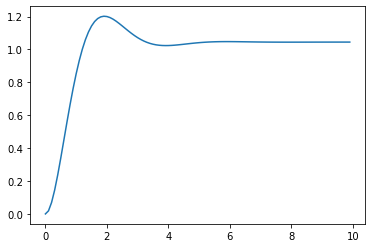

In [21]:
import scipy.integrate
import numpy as np
tf = 10
res = scipy.integrate.solve_ivp(
    fun=lambda t, x: np.array(f_rhs(x, 1.0, [1, 2, 3])).reshape(-1),
    t_span=[0,tf], 
    y0 = [0, 0], t_eval=np.arange(0, tf, 0.1))
plt.plot(res['t'], res['y'][0,:]);

In [6]:
A = ca.jacobian(xv_dot, xv)
A

SX(
[[00, 1], 
 [(-((k+cos(x_0))/m)), (-(c/m))]])

In [7]:
B = ca.jacobian(xv_dot, u)
B

SX([00, (1./m)])

In [8]:
C = ca.jacobian(y, xv)
C

SX([[1, 00]])

In [9]:
D = ca.jacobian(y, u)
D

SX(00)

In [10]:
f_ss = ca.Function('f_A', [xv, p], [A, B, C, D], ['x', 'p'], ['A', 'B', 'C', 'D'])
f_ss

Function(f_A:(x[2],p[3])->(A[2x2,3nz],B[2x1,1nz],C[1x2,1nz],D[1x1,0nz]) SXFunction)

In [11]:
import control
sys = control.ss(*f_ss([0, 0], [1, 2, 3]))
sys

A = [[ 0.  1.]
 [-4. -2.]]

B = [[0.]
 [1.]]

C = [[1. 0.]]

D = [[0.]]

In [12]:
f_rhs.generate('rhs.c')
#!cat rhs.c

'rhs.c'

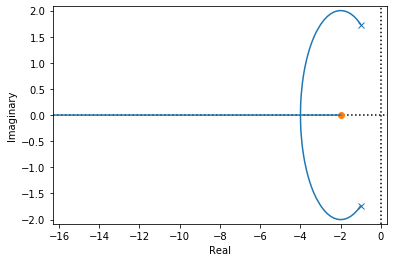

In [13]:
s = control.TransferFunction([1, 0],[0, 1]);
H = (s + 2)
control.rlocus(H*sys);

# Linear Time Invariant Systems (LTI)

* Transfer Functions: $G(s) = s/(s+1)$
* State-space: $\dot{x} = Ax + Bu$, $y = Cx + Du$
* Impulse response function: $g(t)$

* $\dot{x} = a_1 x + a_2 x + b u$, $y = c x + du$ Linear? -> Yes Bevause A = A1 + A2
* $\dot{x} = a_1 x + 3 + b u$, $y = c x + du$ Linear? -> No, not a linear system

* What u would balance this equation at x=0? -> u_0 = -3/b (trim input)

* For compensated dynamics to be $G(s) = 1/(s+1)$, u(x)?

* LTI $\implies zero in -> zero out

# Trimming the Mas-Spring-Damper System

In [23]:
f_rhs([0, 0], [-3], [1, 2, 3])

DM([0, 0])

$\dot{x}= Ax + Bu$, $y  = Cx + Du +3$ -> non-linear (violates zero in zero out)

Trimming an aircraft eans, finding where the rhs = 0, or $f(t,x) = 0$, in order to do this we watn to monimize \dot{f(u,x)

In [ ]:
def trim_function(xv_dot):
    reture xvdot[0] + 